In [5]:
import os
import tensorflow as tf
from model import Model
from input_pipe import InputPipe
from feeder import VarFeeder
from tqdm import trange
import matplotlib.pyplot as plt
import collections
import pandas as pd
import numpy as np
from trainer import predict
from hparams import build_hparams
import hparams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [17]:
def smape(true, pred):
    summ = np.abs(true) + np.abs(pred)
    smape = np.where(summ == 0, 0, np.abs(true - pred) / summ)
    return smape

def mae(true, pred):
    return np.abs(np.abs(true) - np.abs(pred))

def mean_smape(true, pred):
    raw_smape = smape(true, pred)
    masked_smape = np.ma.array(raw_smape, mask=np.isnan(raw_smape))
    return masked_smape.mean()

def mean_mae(true, pred):
    raw_mae = mae(true, pred)
    masked_mae = np.ma.array(raw_mae, mask=np.isnan(raw_mae))
    return masked_mae.mean()

def predict_loss(prev, paths):
    # prev: true value
    # paths: paths to the model weights
    t_preds = []
    for tm in range(3):
        tf.reset_default_graph()
        t_preds.append(predict(paths[-1:], build_hparams(hparams.params_s32), back_offset=0, predict_window=288,
                        n_models=3, target_model=tm, seed=2, batch_size=50, asgd=True))
    preds=sum(t_preds) /3
    # mean mae
    res = 0
    for idx in preds.index:
        res += np.abs(preds.loc[idx, :] - prev.iloc[idx, -288:]).sum()
    res /= len(preds.index) * 288
    return preds, res

def split_data(df):
    bad_path = os.path.join('/nfs/project/lihaocheng/badcase', 'single_rnn_mae_beyond_1000_vm_uuids')
    bad_df = pd.DataFrame()
    normal_df = df.copy()
    with open(bad_path, 'r') as f:
        line = f.readline()
        while(line):
            line = line[:-1] + ".hdf5"
            if line in df.index:
                bad_df = bad_df.append(df.loc[line])
                normal_df = normal_df.drop(line)
            line = f.readline()
    return bad_df.sort_index(), normal_df.sort_index()

def show_single(preds, prev, vm, scope=288, bad_case=True):
    name = prev.index[vm]
    '''
    if bad_case:
        bad_path = os.path.join('/nfs/project/lihaocheng/badcase', 'single_rnn_mae_beyond_1000_vm_uuids')
        bad_list = []
        with open(bad_path, 'r') as f:
            line = f.readline()
            while(line):
                line = line[:-1] + ".hdf5"
                if line in preds.index:
                    bad_list.append(line)
                line = f.readline()
        name = bad_list[vm]
    '''
    
    # mean mae for each row
    print(f'vm name: {name}')
    prev.loc[name, ends[vm] - scope :].plot(logy=True)
    (preds.iloc[vm, :]).plot(logy=True)
    # mean loss
    print(mean_mae(prev.loc[name, - 288 :], preds.iloc[vm, :]))

In [3]:
from make_features import read_all, find_start_end
dfs = read_all('/nfs/isolation_project/intern/project/lihaocheng/vm/')
df = dfs[0].iloc[:, 0:-288]
starts, ends = find_start_end(df.values)
page_mask = (ends - starts) / df.shape[1] < 0.04
print("Masked %d vms from %d" % (page_mask.sum(), len(df)))
inv_mask = ~page_mask
df = dfs[0][inv_mask]
prev = df.apply(lambda x : np.exp(x) - 1).sort_index()

Masked 630 vms from 4037


In [6]:
paths = [p for p in tf.train.get_checkpoint_state(os.path.join('data/cpt', 's32')).all_model_checkpoint_paths]
preds, loss = predict_loss(prev, paths)
loss

INFO:tensorflow:Restoring parameters from data/vars/feeder.cpt
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-220
0....................................................................🎉
INFO:tensorflow:Restoring parameters from data/vars/feeder.cpt
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-220
0....................................................................🎉
INFO:tensorflow:Restoring parameters from data/vars/feeder.cpt
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-220
0....................................................................🎉


393.46513712762066

Visual sanity check

vm name: 08980ea38afc5daba83bf1b1204e1e97.hdf5
1311.0374620225693


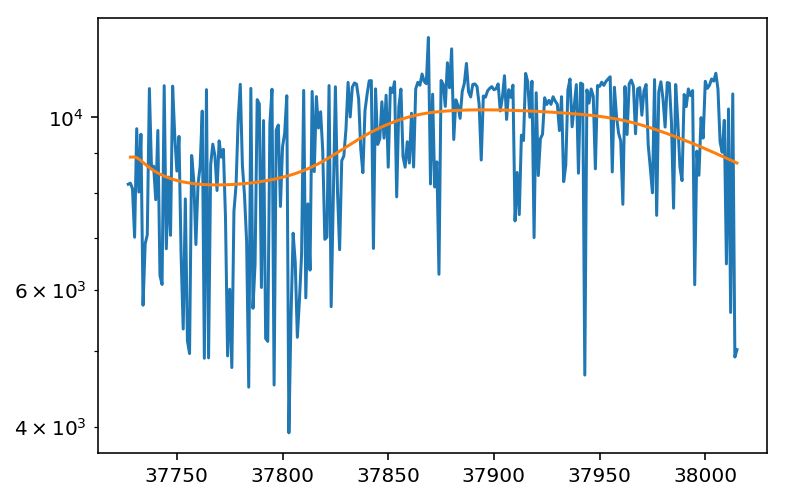

In [26]:
show_single(preds, prev, 120, 0)

In [86]:
from statsmodels.stats import diagnostic as diag
n=120
res = preds.loc[n, :] - prev.iloc[n, -288:]

# indep degree = 30
white_noise = diag.acorr_ljungbox(res, lags=[30])[1][0]
white_noise

0.0340337549240487